# Data Pre-Processing

In [7]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import pickle
from project_functions import save_data_to_csv

In [8]:
# input training data

# specify maps used for training to find training data folders in current directory
train_maps = ['4way', 'small_loop', 'small_loop_cw', 'straight_road', 'zigzag_dists']
train_folders = [f"train_data/train_data_{map_name}" for map_name in train_maps]

# define pattern to match .csv files
pattern = '*.csv'

# list to store csv file paths
csv_fps = []

# iterate through file paths
for folder in train_folders:
    # get all csvs in current folder
    csv_files = glob.glob(os.path.join(folder, pattern))
    # extend list of csv file paths with files in current folder
    csv_fps.extend(csv_files)


## PD - Raw Data

In [9]:
# initialise master dataframe of all training data
df = pd.concat([pd.read_csv(fp) for fp in csv_fps], ignore_index=True)

df.drop('timestep', axis=1, inplace=True)
df.drop('car_speed', axis=1, inplace=True)
df.drop('total_reward', axis=1, inplace=True)

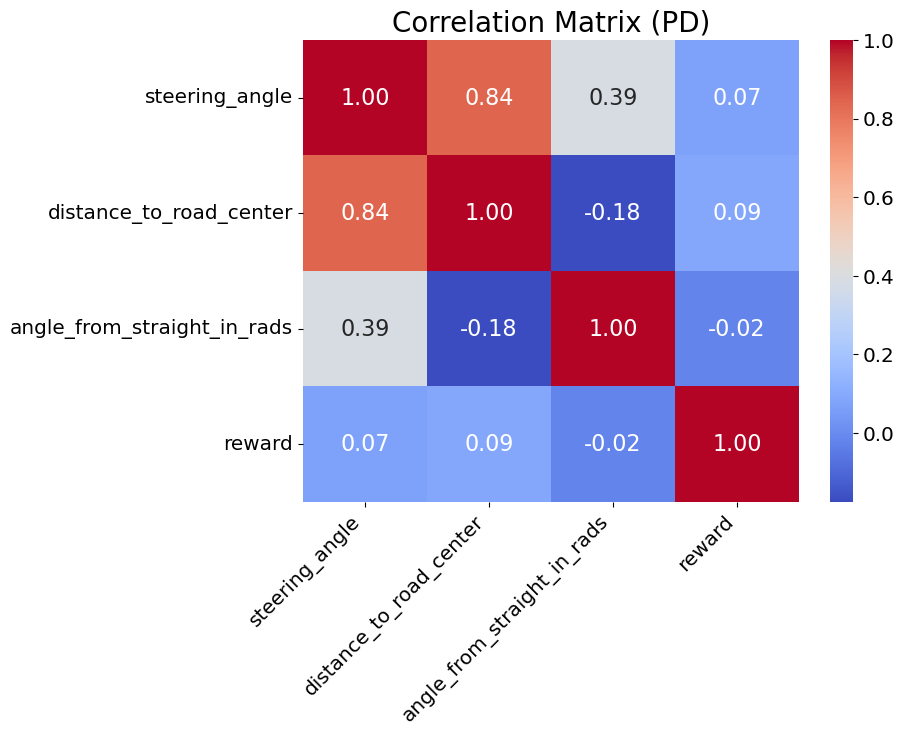

In [10]:
# correlation matrix
corr_matrix = df.corr()

# visualise matrix
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            annot_kws={"size": 16})

plt.title('Correlation Matrix (PD)', fontsize=20)
plt.xticks(fontsize='x-large', horizontalalignment='right', rotation=45)
plt.yticks(fontsize='x-large')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize='x-large')
plt.show()

For 2 components:
Singular values: [795.30168636 169.40678616]
Variance ratios: [0.94706767 0.04297133]
For 3 components:
Singular values: [795.30168636 169.40678616  81.56291605]
Variance ratios: [0.94706767 0.04297133 0.00996099]
For 4 components:
Singular values: [7.95301686e+02 1.69406786e+02 8.15629161e+01 2.44291027e-14]
Variance ratios: [9.47067674e-01 4.29713318e-02 9.96099438e-03 8.93577526e-34]


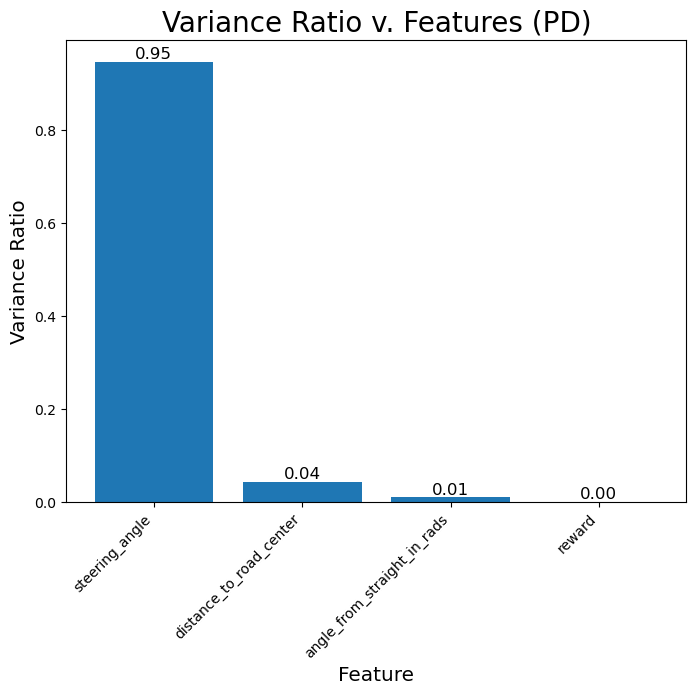

In [11]:
# PCA analysis
def PCA(n, df):
    '''Function for PCA analysis'''
    pca = decomposition.PCA(n_components=n)
    pca.fit_transform(df)

    sing_vals = pca.singular_values_
    var_ratios = pca.explained_variance_ratio_

    print(f"For {n} components:")
    print(f"Singular values: {sing_vals}")
    print(f"Variance ratios: {var_ratios}")

    return var_ratios

var_ratios2 = PCA(2, df)
var_ratios3 = PCA(3, df)
var_ratios4 = PCA(4, df)

# plot variance ratio v. number of features
plt.figure(figsize=(8, 6))
bars = plt.bar(range(1, len(var_ratios4)+1), var_ratios4)

for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.xlabel('Feature', fontsize='x-large')
plt.ylabel('Variance Ratio', fontsize='x-large')
plt.xticks(range(1, 5), ["steering_angle", "distance_to_road_center", "angle_from_straight_in_rads", "reward"], rotation=45, ha='right', fontsize='medium')
plt.yticks(fontsize='medium')
plt.title('Variance Ratio v. Features (PD)', fontsize=20)
plt.show()

In [12]:
print("DNN training data before normalisation:")
display(df)

# normalise data
scaler = StandardScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# save scaling parameters
scaling_params = {
    'mean': scaler.mean_,
    'scale': scaler.scale_
}

# create folder for models
if not os.path.exists("train_data"):
    os.makedirs("train_data")

with open('train_data/raw_data_pd_scaling_params.pkl', 'wb') as file:
    pickle.dump(scaling_params, file)

print("DNN training data after normalisation:")
display(df_norm)

# print scaling parameters
scaling_params_df = pd.DataFrame(columns=df_norm.columns)
scaling_params_df.loc[len(scaling_params_df)] = scaler.mean_
scaling_params_df.loc[len(scaling_params_df)] = scaler.scale_
scaling_params_df = scaling_params_df.rename(index={0: 'mean', 1: 'scale'})
print("Scaling parameters for normalisation:")
display(scaling_params_df)

DNN training data before normalisation:


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,-0.937963,-0.064416,-0.293800,0.504417
1,-0.937963,-0.064416,-0.293800,0.504417
2,-0.937963,-0.064416,-0.293800,0.504417
3,-0.937963,-0.064416,-0.293800,0.504417
4,-0.937963,-0.064416,-0.293800,0.503940
...,...,...,...,...
124995,0.067777,0.005244,0.015342,-8.172504
124996,0.067025,0.005278,0.014245,-8.124356
124997,0.066256,0.005310,0.013157,-8.075805
124998,0.065469,0.005339,0.012076,-8.026854


DNN training data after normalisation:


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,-2.017271,-1.449541,-1.197695,0.022491
1,-2.017271,-1.449541,-1.197695,0.022491
2,-2.017271,-1.449541,-1.197695,0.022491
3,-2.017271,-1.449541,-1.197695,0.022491
4,-2.017271,-1.449541,-1.197695,0.022279
...,...,...,...,...
124995,0.144081,0.147693,0.010285,-3.835282
124996,0.142465,0.148484,0.006000,-3.813875
124997,0.140811,0.149215,0.001745,-3.792289
124998,0.139120,0.149889,-0.002478,-3.770526


Scaling parameters for normalisation:


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
mean,0.000732,-0.001198,0.012710,0.453830
scale,0.465329,0.043613,0.255917,2.249205


In [13]:
# save data into csv
data = df_norm.to_dict(orient='dict')
display(df_norm.head())
save_data_to_csv(foldername="train_data", filename="raw_data_pd.csv", data=data)

,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,-2.017271,-1.449541,-1.197695,0.022491
1,-2.017271,-1.449541,-1.197695,0.022491
2,-2.017271,-1.449541,-1.197695,0.022491
3,-2.017271,-1.449541,-1.197695,0.022491
4,-2.017271,-1.449541,-1.197695,0.022279


Saved raw_data_pd.csv


## PD - Processed Data

In [14]:
# outlier detection
def detect_outliers(df, feature, window_size, threshold):
    '''Function to detect outliers using rolling statistics for a given feature'''
    rolling_mean = df[feature].rolling(window=window_size).mean()
    rolling_std = df[feature].rolling(window=window_size).std()
    outliers = np.abs(df[feature] - rolling_mean) > threshold * rolling_std
    return outliers

# define rolling window size and threshold
window_size = 50
threshold = 3

# list of features to apply outlier detection
features = ["steering_angle", "distance_to_road_center", "angle_from_straight_in_rads", "reward"]

# initialise list for all clean data
clean_data = []

# apply outlier detection to some features of each simulation run
for fp in csv_fps:
    run_df = pd.read_csv(fp)
    # drop irrelevant features
    run_df.drop('timestep', axis=1, inplace=True)
    run_df.drop('car_speed', axis=1, inplace=True)
    run_df.drop('total_reward', axis=1, inplace=True)

    outliers_df = pd.DataFrame(index=df.index) # initialise dataframe to store outlier flags
    
    for feature in features:
        outliers_df[feature] = detect_outliers(run_df, feature, window_size, threshold)
    outliers_combined = outliers_df.any(axis=1) # combine outliers from all features
    outliers_indices = df.index[outliers_combined].tolist()
    clean_df = run_df.drop(outliers_indices)
    clean_data.append(clean_df)

df = pd.concat(clean_data, ignore_index=True)
display(df)
    

,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,-0.937963,-0.064416,-0.293800,0.504417
1,-0.937963,-0.064416,-0.293800,0.504417
2,-0.937963,-0.064416,-0.293800,0.504417
3,-0.937963,-0.064416,-0.293800,0.504417
4,-0.937963,-0.064416,-0.293800,0.503940
...,...,...,...,...
121289,0.068511,0.005207,0.016446,-8.220245
121290,0.067777,0.005244,0.015342,-8.172504
121291,0.067025,0.005278,0.014245,-8.124356
121292,0.066256,0.005310,0.013157,-8.075805


In [15]:
# remove duplicate data
df = df.drop_duplicates()

display(df)

,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,-0.937963,-0.064416,-0.293800,0.504417
4,-0.937963,-0.064416,-0.293800,0.503940
5,-0.937227,-0.064528,-0.291943,0.503094
6,-0.935797,-0.064732,-0.288476,0.501971
7,-0.933704,-0.065009,-0.283615,0.500648
...,...,...,...,...
121289,0.068511,0.005207,0.016446,-8.220245
121290,0.067777,0.005244,0.015342,-8.172504
121291,0.067025,0.005278,0.014245,-8.124356
121292,0.066256,0.005310,0.013157,-8.075805


In [16]:
# only keep samples with positive rewards
df = df[df['reward'] > 0]

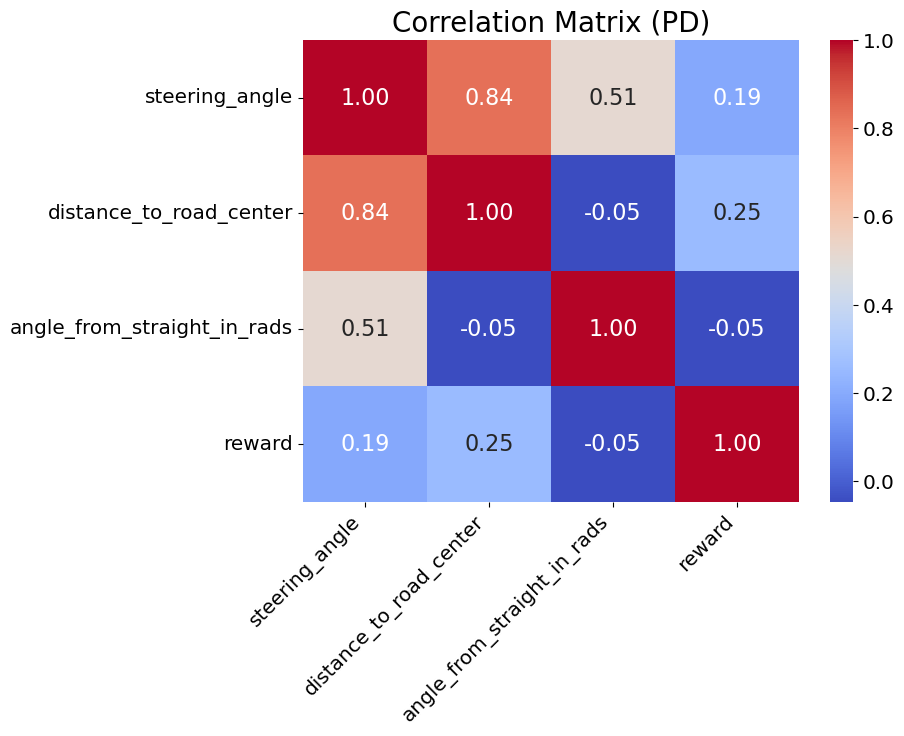

In [17]:
# correlation matrix
corr_matrix = df.corr()

# visualise matrix
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            annot_kws={"size": 16})

plt.title('Correlation Matrix (PD)', fontsize=20)
plt.xticks(fontsize='x-large', horizontalalignment='right', rotation=45)
plt.yticks(fontsize='x-large')
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize='x-large')
plt.show()

For 2 components:
Singular values: [141.89894397  92.41000932]
Variance ratios: [0.62669397 0.26578791]
For 3 components:
Singular values: [141.89894397  92.41000932  58.77494466]
Variance ratios: [0.62669397 0.26578791 0.10751812]
For 4 components:
Singular values: [1.41898944e+02 9.24100093e+01 5.87749447e+01 4.92473440e-17]
Variance ratios: [6.26693974e-01 2.65787909e-01 1.07518117e-01 7.54853751e-38]


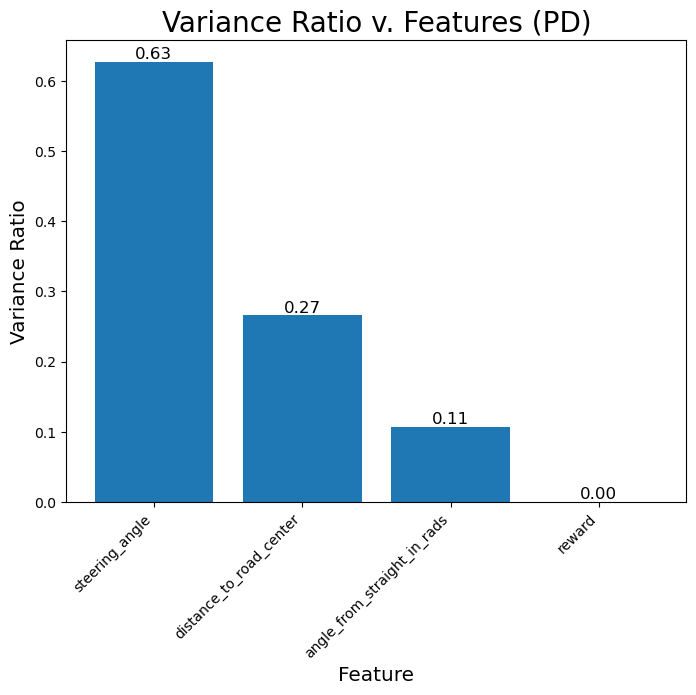

In [18]:
# PCA analysis
def PCA(n, df):
    '''Function for PCA analysis'''
    pca = decomposition.PCA(n_components=n)
    pca.fit_transform(df)

    sing_vals = pca.singular_values_
    var_ratios = pca.explained_variance_ratio_

    print(f"For {n} components:")
    print(f"Singular values: {sing_vals}")
    print(f"Variance ratios: {var_ratios}")

    return var_ratios

var_ratios2 = PCA(2, df)
var_ratios3 = PCA(3, df)
var_ratios4 = PCA(4, df)

# plot variance ratio v. number of features
plt.figure(figsize=(8, 6))
bars = plt.bar(range(1, len(var_ratios4)+1), var_ratios4)

for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.xlabel('Feature', fontsize='x-large')
plt.ylabel('Variance Ratio', fontsize='x-large')
plt.xticks(range(1, 5), ["steering_angle", "distance_to_road_center", "angle_from_straight_in_rads", "reward"], rotation=45, ha='right', fontsize='medium')
plt.yticks(fontsize='medium')
plt.title('Variance Ratio v. Features (PD)', fontsize=20)
plt.show()

In [19]:
print("DNN training data before normalisation:")
display(df)
# normalise data
scaler = StandardScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# save scaling parameters
scaling_params = {
    'mean': scaler.mean_,
    'scale': scaler.scale_
}

with open('train_data/processed_data_pd_scaling_params.pkl', 'wb') as file:
    pickle.dump(scaling_params, file)

print("DNN training data after normalisation:")
display(df_norm)

# print scaling parameters
scaling_params_df = pd.DataFrame(columns=df_norm.columns)
scaling_params_df.loc[len(scaling_params_df)] = scaler.mean_
scaling_params_df.loc[len(scaling_params_df)] = scaler.scale_
scaling_params_df = scaling_params_df.rename(index={0: 'mean', 1: 'scale'})
print("Scaling parameters for normalisation:")
display(scaling_params_df)

DNN training data before normalisation:


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,-0.937963,-0.064416,-0.293800,0.504417
4,-0.937963,-0.064416,-0.293800,0.503940
5,-0.937227,-0.064528,-0.291943,0.503094
6,-0.935797,-0.064732,-0.288476,0.501971
7,-0.933704,-0.065009,-0.283615,0.500648
...,...,...,...,...
120450,0.715580,0.007239,0.643193,0.458246
120451,0.768742,0.008091,0.687831,0.357374
120452,0.774325,0.009562,0.678709,0.256780
120453,0.779573,0.011016,0.669418,0.156464


DNN training data after normalisation:


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,-2.433292,-1.947770,-1.374500,-1.568680
1,-2.433292,-1.947770,-1.374500,-1.570396
2,-2.431446,-1.951035,-1.366037,-1.573436
3,-2.427859,-1.956969,-1.350240,-1.577470
4,-2.422611,-1.965035,-1.328086,-1.582221
...,...,...,...,...
112415,1.713784,0.139723,2.895356,-1.734552
112416,1.847112,0.164552,3.098773,-2.096936
112417,1.861115,0.207394,3.057201,-2.458322
112418,1.874278,0.249750,3.014864,-2.818708


Scaling parameters for normalisation:


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
mean,0.032252,0.002443,0.007825,0.941070
scale,0.398725,0.034326,0.219444,0.278357


In [20]:
# save final dataframe as csv to use for training
filename = "train_data/processed_data_pd.csv"
df_norm.to_csv(filename, encoding='utf-8', index=False)

# Feature Analysis

In [21]:
raw_df = pd.read_csv("train_data/raw_data_pd.csv")
processed_df = pd.read_csv("train_data/processed_data_pd.csv")

In [22]:
display(raw_df.head())
display(processed_df.head())

,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,-2.017271,-1.449541,-1.197695,0.022491
1,-2.017271,-1.449541,-1.197695,0.022491
2,-2.017271,-1.449541,-1.197695,0.022491
3,-2.017271,-1.449541,-1.197695,0.022491
4,-2.017271,-1.449541,-1.197695,0.022279


,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward
0,-2.433292,-1.947770,-1.374500,-1.568680
1,-2.433292,-1.947770,-1.374500,-1.570396
2,-2.431446,-1.951035,-1.366037,-1.573436
3,-2.427859,-1.956969,-1.350240,-1.577470
4,-2.422611,-1.965035,-1.328086,-1.582221


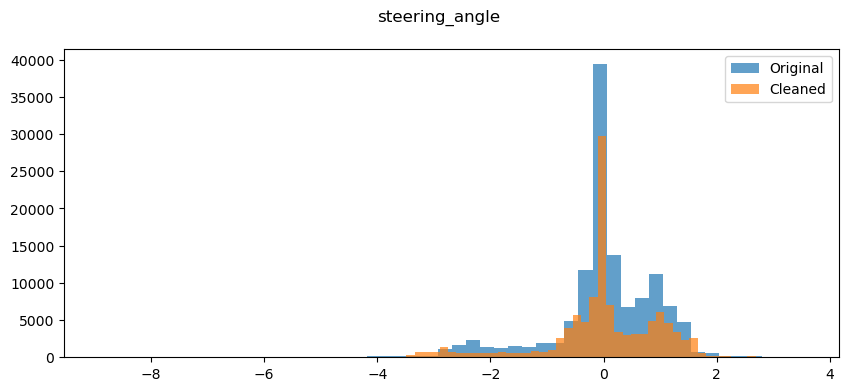

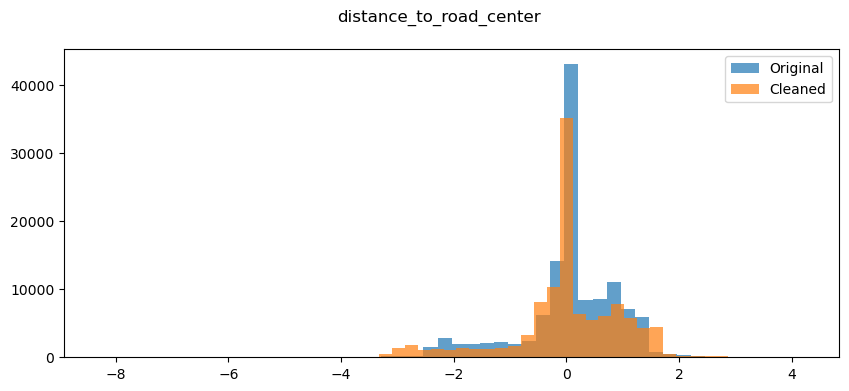

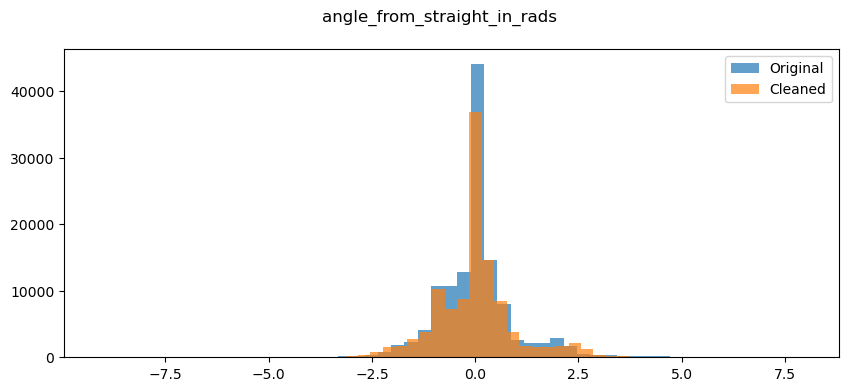

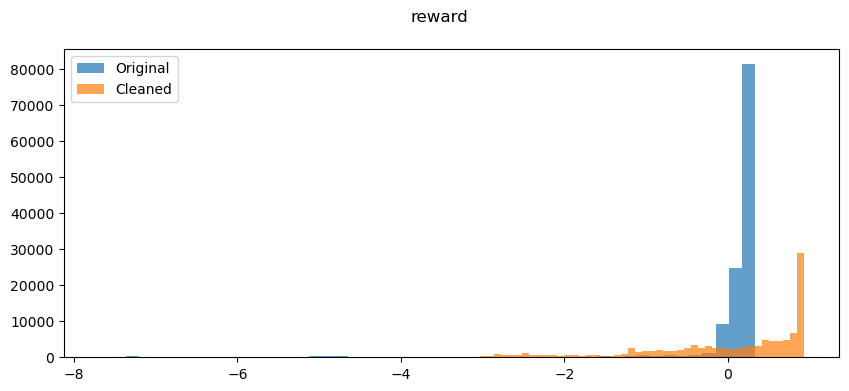

In [23]:
for feature in raw_df.columns:
    plt.figure(figsize=(10, 4))
    plt.hist(raw_df[feature], bins=50, alpha=0.7, label='Original')
    plt.hist(processed_df[feature], bins=50, alpha=0.7, label='Cleaned')
    plt.suptitle(f"{feature}")
    plt.legend()
    plt.show()